In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

In [2]:
df_new = pd.read_csv('Processed_Fatality.csv')

In [3]:
# Prepare modeling data
df_model = df_new.dropna(subset=['delay_hours'])

# Separate target and features
y = df_model['delay_hours']
X = df_model.drop(['delay_hours', 'time_notified', 
                   'datetime_crash', 'datetime_not_crash', 
                   'date_crash','LATITUDE','LONGITUD',
                   'HOSP_HR','HOSP_MN',
                   'TWAY_ID2','OBJECTID',
                   'ST_CASE','FATALS','PEDS','PERSONS',
                   'PERNOTMVIT','PERMVIT','VE_TOTAL','VE_FORMS',
                   'PVH_INVL','x','y','HARM_EV',
                   "tm_crash","not_tm_crash",
                   "HOSP_HRNAME","HOSP_MNNAME",
                   "RAILNAME","SCH_BUSNAME",
                   "MAN_COLLNAME","HARM_EVNAME",'WRK_ZONENAME',
                   "MAN_COLL","LATITUDENAME","LONGITUDNAME",
                   "MINUTENAME","DAYNAME","YEAR","MINUTE","STATENAME"
                   ], axis=1)


In [4]:
# Find columns that have both 'COLNAME' and 'COL' versions (where we want to keep 'COLNAME' and exclude 'COL')
cols_with_name_suffix = [col for col in X.columns if col.endswith('NAME')]
base_cols_to_exclude = []

for col_with_name in cols_with_name_suffix:
    # Remove 'NAME' suffix to get the base column name
    base_col = col_with_name[:-4]  # Remove last 4 characters ('NAME')
    
    # Check if the base column exists in the dataframe
    if base_col in X.columns:
        base_cols_to_exclude.append(base_col)
        print(f"Found pair: {base_col} and {col_with_name} - excluding {base_col}")

# Exclude columns that start with 'NOT' or 'ARR'
cols_to_exclude_start = [col for col in X.columns if col.startswith('NOT') or col.startswith('ARR')]

# Combine all columns to exclude
cols_to_exclude = list(set(cols_to_exclude_start + base_cols_to_exclude))

print(f"\nAll columns to exclude: {cols_to_exclude}")


Found pair: COUNTY and COUNTYNAME - excluding COUNTY
Found pair: CITY and CITYNAME - excluding CITY
Found pair: MONTH and MONTHNAME - excluding MONTH
Found pair: DAY_WEEK and DAY_WEEKNAME - excluding DAY_WEEK
Found pair: HOUR and HOURNAME - excluding HOUR
Found pair: ROUTE and ROUTENAME - excluding ROUTE
Found pair: RUR_URB and RUR_URBNAME - excluding RUR_URB
Found pair: FUNC_SYS and FUNC_SYSNAME - excluding FUNC_SYS
Found pair: RD_OWNER and RD_OWNERNAME - excluding RD_OWNER
Found pair: NHS and NHSNAME - excluding NHS
Found pair: SP_JUR and SP_JURNAME - excluding SP_JUR
Found pair: MILEPT and MILEPTNAME - excluding MILEPT
Found pair: RELJCT1 and RELJCT1NAME - excluding RELJCT1
Found pair: RELJCT2 and RELJCT2NAME - excluding RELJCT2
Found pair: TYP_INT and TYP_INTNAME - excluding TYP_INT
Found pair: REL_ROAD and REL_ROADNAME - excluding REL_ROAD
Found pair: LGT_COND and LGT_CONDNAME - excluding LGT_COND
Found pair: WEATHER and WEATHERNAME - excluding WEATHER
Found pair: NOT_HOUR and NOT

In [5]:
# Drop the excluded columns that exist in the DataFrame
X = X.drop(columns=[col for col in cols_to_exclude if col in X.columns])

In [6]:
X.shape

(14239, 24)

In [7]:
categorical_cols = X.select_dtypes(include=['object']).columns
categorical_cols

Index(['COUNTYNAME', 'CITYNAME', 'MONTHNAME', 'DAY_WEEKNAME', 'HOURNAME',
       'TWAY_ID', 'ROUTENAME', 'RUR_URBNAME', 'FUNC_SYSNAME', 'RD_OWNERNAME',
       'NHSNAME', 'SP_JURNAME', 'MILEPTNAME', 'RELJCT1NAME', 'RELJCT2NAME',
       'TYP_INTNAME', 'REL_ROADNAME', 'LGT_CONDNAME', 'WEATHERNAME', 'RAIL'],
      dtype='object')

In [8]:
encoder = ce.TargetEncoder(cols=categorical_cols)
X = encoder.fit_transform(X, y)
X.shape

(14239, 24)

In [9]:
# Keep only numeric features
# X = X.select_dtypes(include=[np.number])

# Handle infinite values and missing data
X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.loc[X.index]

print(f"Dataset shape: {X.shape}")
print(f"Target variable range: {y.min():.2f} to {y.max():.2f} hours")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dataset shape: (14239, 24)
Target variable range: 0.00 to 1428.00 hours


In [10]:
#############################################
# Linear Regression Model
#############################################
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Metrics for Linear Regression
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
r2_linear = r2_score(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)

print("\n=== Linear Regression Results ===")
print(f"RMSE: {rmse_linear:.4f}")
print(f"R²: {r2_linear:.4f}")
print(f"MAE: {mae_linear:.4f}")

#############################################
# Random Forest Regression Model
#############################################
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Metrics for Random Forest
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("\n=== Random Forest Results ===")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²: {r2_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")

#############################################
# XGBoost Regression Model
#############################################
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Metrics for XGBoost
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print("\n=== XGBoost Results ===")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"R²: {r2_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")

#############################################
# Feature Importance Analysis
#############################################
# Get feature importance from Random Forest
rf_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# Get feature importance from XGBoost
xgb_importance = pd.Series(xgb_model.feature_importances_, index=X_train.columns)

# Combine top features from both models
top_rf_features = rf_importance.sort_values(ascending=False).head(10)
top_xgb_features = xgb_importance.sort_values(ascending=False).head(10)

print("\n=== Top 10 Features from Random Forest ===")
for feature, importance in top_rf_features.items():
    print(f"{feature}: {importance:.4f}")

print("\n=== Top 10 Features from XGBoost ===")
for feature, importance in top_xgb_features.items():
    print(f"{feature}: {importance:.4f}")


=== Linear Regression Results ===
RMSE: 26.8626
R²: 0.4851
MAE: 11.8619

=== Random Forest Results ===
RMSE: 24.6561
R²: 0.5662
MAE: 4.6597

=== XGBoost Results ===
RMSE: 32.4443
R²: 0.2489
MAE: 5.4798

=== Top 10 Features from Random Forest ===
TWAY_ID: 0.5863
COUNTYNAME: 0.1575
MILEPTNAME: 0.0776
HOURNAME: 0.0384
CITYNAME: 0.0302
STATE: 0.0183
DAY_WEEKNAME: 0.0147
MONTHNAME: 0.0131
DAY: 0.0127
WEATHERNAME: 0.0097

=== Top 10 Features from XGBoost ===
TWAY_ID: 0.2547
HOURNAME: 0.1295
NHSNAME: 0.1171
COUNTYNAME: 0.0966
MILEPTNAME: 0.0833
REL_ROADNAME: 0.0604
LGT_CONDNAME: 0.0423
DAY_WEEKNAME: 0.0417
CITYNAME: 0.0381
FUNC_SYSNAME: 0.0246


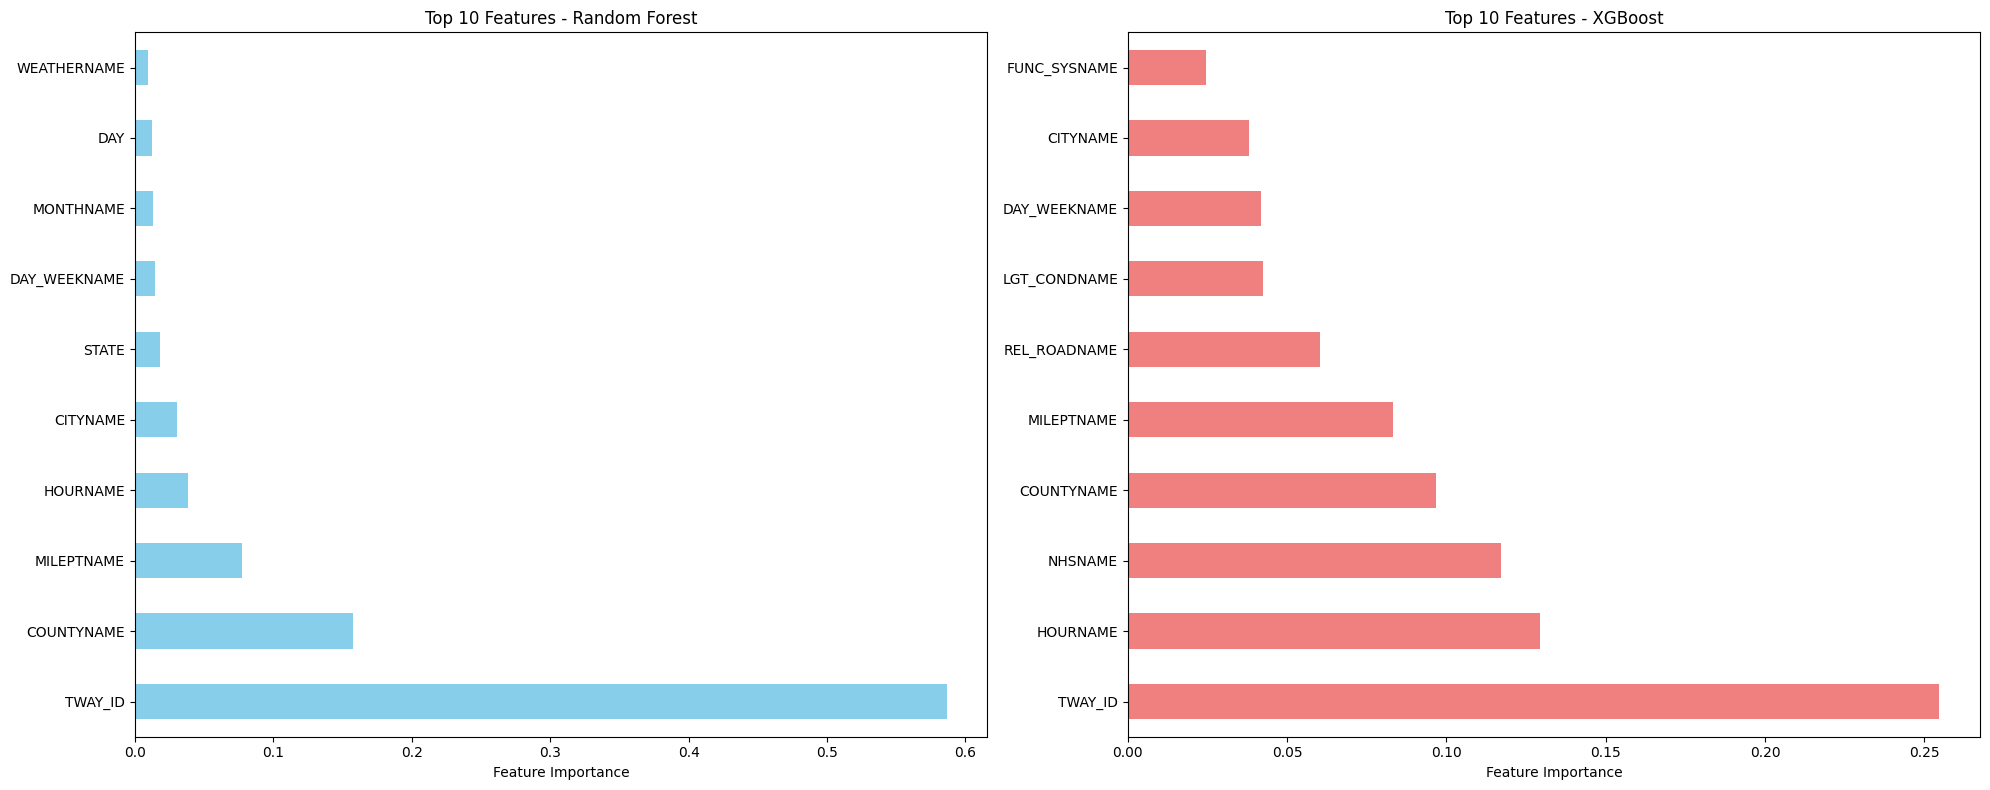

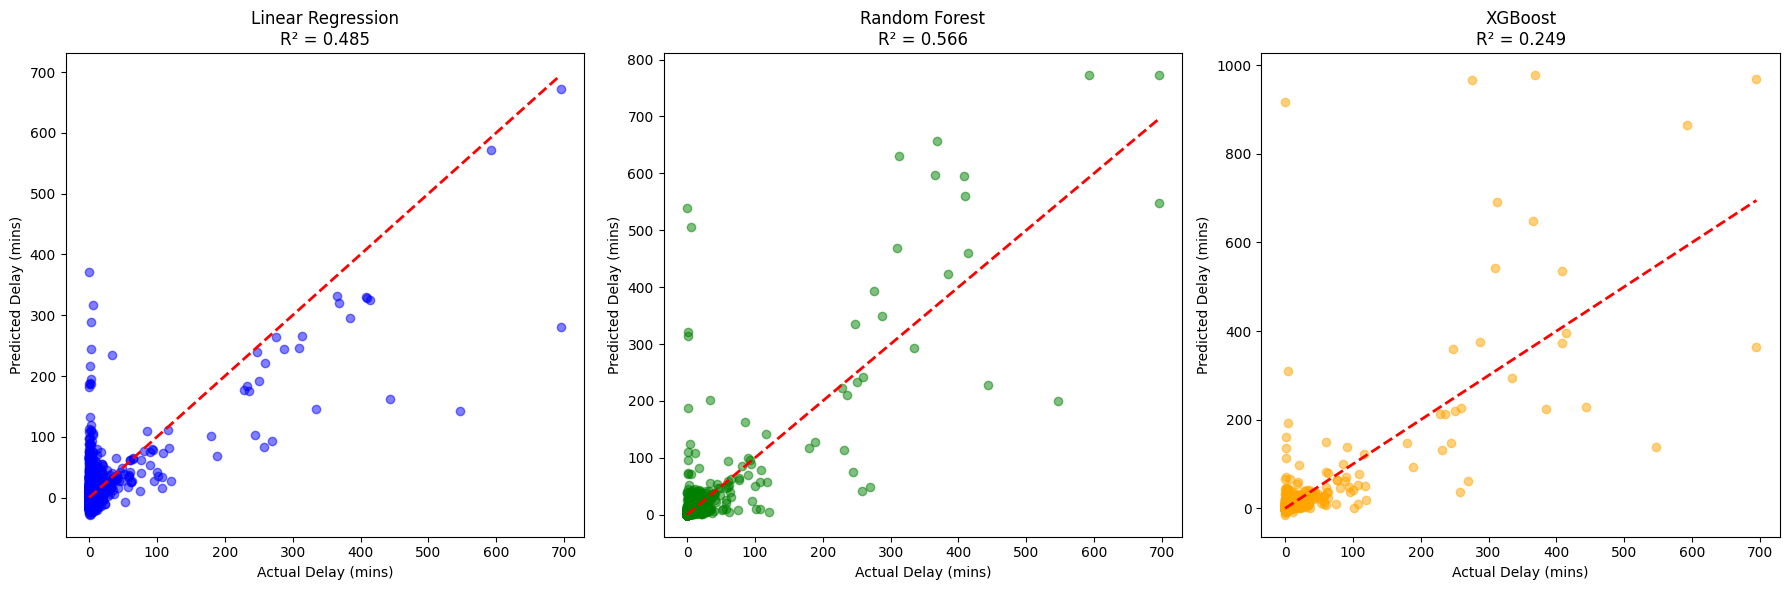

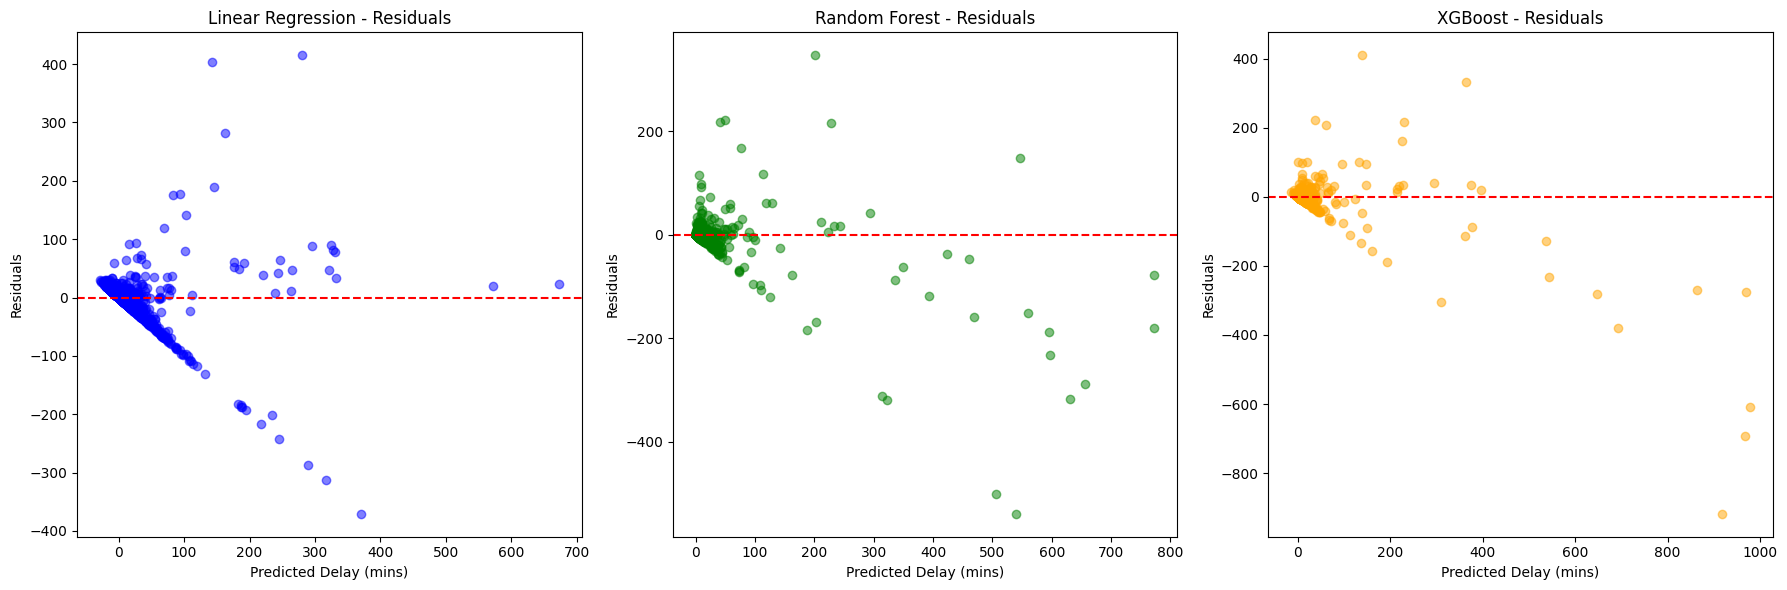

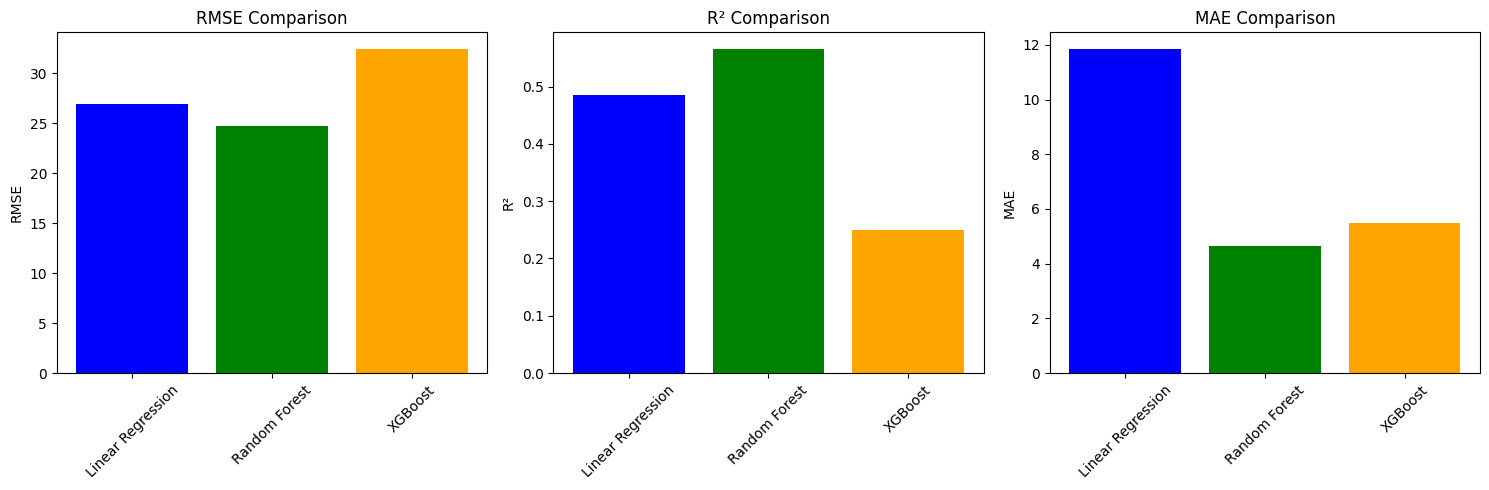


=== Model Comparison ===
               Model       RMSE        R²        MAE
0  Linear Regression  26.862610  0.485114  11.861866
1      Random Forest  24.656060  0.566227   4.659668
2            XGBoost  32.444295  0.248911   5.479754

=== Best Models ===
Best RMSE (lowest): Random Forest
Best R² (highest): Random Forest
Best MAE (lowest): Random Forest


In [11]:
# 1. Feature Importance Plot - Side by side comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Random Forest Feature Importance
top_rf_features.plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Top 10 Features - Random Forest')
axes[0].set_xlabel('Feature Importance')

# XGBoost Feature Importance
top_xgb_features.plot(kind='barh', ax=axes[1], color='lightcoral')
axes[1].set_title('Top 10 Features - XGBoost')
axes[1].set_xlabel('Feature Importance')

plt.tight_layout()
plt.show()

# 2. Predicted vs Actual for all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Linear Regression
axes[0].scatter(y_test, y_pred_linear, alpha=0.5, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Delay (mins)')
axes[0].set_ylabel('Predicted Delay (mins)')
axes[0].set_title(f'Linear Regression\nR² = {r2_linear:.3f}')

# Random Forest
axes[1].scatter(y_test, y_pred_rf, alpha=0.5, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Delay (mins)')
axes[1].set_ylabel('Predicted Delay (mins)')
axes[1].set_title(f'Random Forest\nR² = {r2_rf:.3f}')

# XGBoost
axes[2].scatter(y_test, y_pred_xgb, alpha=0.5, color='orange')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Delay (mins)')
axes[2].set_ylabel('Predicted Delay (mins)')
axes[2].set_title(f'XGBoost\nR² = {r2_xgb:.3f}')

plt.tight_layout()
plt.show()

# 3. Residuals plot for all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Linear regression residuals
residuals_linear = y_test - y_pred_linear
axes[0].scatter(y_pred_linear, residuals_linear, alpha=0.5, color='blue')
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_xlabel('Predicted Delay (mins)')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Linear Regression - Residuals')

# Random forest residuals
residuals_rf = y_test - y_pred_rf
axes[1].scatter(y_pred_rf, residuals_rf, alpha=0.5, color='green')
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Delay (mins)')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Random Forest - Residuals')

# XGBoost residuals
residuals_xgb = y_test - y_pred_xgb
axes[2].scatter(y_pred_xgb, residuals_xgb, alpha=0.5, color='orange')
axes[2].axhline(y=0, color='r', linestyle='--')
axes[2].set_xlabel('Predicted Delay (mins)')
axes[2].set_ylabel('Residuals')
axes[2].set_title('XGBoost - Residuals')

plt.tight_layout()
plt.show()

# 4. Model Performance Comparison Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

models = ['Linear Regression', 'Random Forest', 'XGBoost']
rmse_values = [rmse_linear, rmse_rf, rmse_xgb]
r2_values = [r2_linear, r2_rf, r2_xgb]
mae_values = [mae_linear, mae_rf, mae_xgb]

# RMSE Comparison
axes[0].bar(models, rmse_values, color=['blue', 'green', 'orange'])
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE Comparison')
axes[0].tick_params(axis='x', rotation=45)

# R² Comparison
axes[1].bar(models, r2_values, color=['blue', 'green', 'orange'])
axes[1].set_ylabel('R²')
axes[1].set_title('R² Comparison')
axes[1].tick_params(axis='x', rotation=45)

# MAE Comparison
axes[2].bar(models, mae_values, color=['blue', 'green', 'orange'])
axes[2].set_ylabel('MAE')
axes[2].set_title('MAE Comparison')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#############################################
# Model Comparison Summary (Updated)
#############################################
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'RMSE': [rmse_linear, rmse_rf, rmse_xgb],
    'R²': [r2_linear, r2_rf, r2_xgb],
    'MAE': [mae_linear, mae_rf, mae_xgb]
})

print("\n=== Model Comparison ===")
print(comparison_df)

# Find best model for each metric
best_rmse = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']
best_r2 = comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']
best_mae = comparison_df.loc[comparison_df['MAE'].idxmin(), 'Model']

print(f"\n=== Best Models ===")
print(f"Best RMSE (lowest): {best_rmse}")
print(f"Best R² (highest): {best_r2}")
print(f"Best MAE (lowest): {best_mae}")

In [12]:
# Combine coefficients and feature importances into a table

# Model 1: Linear Regression coefficients
linear_coeffs = pd.Series(linear_model.coef_, index=X_train.columns)

# Model 2: Random Forest feature importances
rf_imp = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# Model 3: XGBoost feature importances
xgb_imp = pd.Series(xgb_model.feature_importances_, index=X_train.columns)

# Create a DataFrame containing all three metrics
importance_df = pd.DataFrame({
    "Linear Coeff": linear_coeffs,
    "RF Importance": rf_imp,
    "XGB Importance": xgb_imp
})

# Optionally, sort by absolute linear coefficient values in descending order
importance_df = importance_df.reindex(linear_coeffs.abs().sort_values(ascending=False).index)

print("Predictors for EMS Delay Models with Coefficients / Importances:")
display(importance_df.style.format("{:.4f}"))

Predictors for EMS Delay Models with Coefficients / Importances:


,Linear Coeff,RF Importance,XGB Importance
TWAY_ID,5.4339,0.5863,0.2547
SCH_BUS,-2.0551,0.0000,0.0001
COUNTYNAME,1.8217,0.1575,0.0966
RAIL,1.2652,0.0000,0.0003
MILEPTNAME,0.9534,0.0776,0.0833
RELJCT1NAME,0.8677,0.0009,0.0023
MONTHNAME,0.6399,0.0131,0.0173
ROUTENAME,-0.5858,0.0073,0.0237
CITYNAME,0.5030,0.0302,0.0381
HOURNAME,0.4668,0.0384,0.1295


In [13]:
importance_df.to_csv('model_importance_comparison.csv', index=True)

In [14]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import numpy as np

# Get the feature names from the trained model
feature_names = X_train.columns.tolist()

# Create dropdown widgets for each feature
dropdown_widgets = {}
widget_list = []

print("Creating interactive prediction interface...")

for feature in feature_names:
    # Get unique values or create reasonable range for each feature
    if feature in df_model.columns:
        unique_vals = sorted(df_model[feature].dropna().unique())
        
        # For continuous variables with many unique values, create a slider instead
        if len(unique_vals) > 20 and df_model[feature].dtype in ['int64', 'float64']:
            min_val = df_model[feature].min()
            max_val = df_model[feature].max()
            default_val = df_model[feature].median()
            
            widget = widgets.FloatSlider(
                value=default_val,
                min=min_val,
                max=max_val,
                step=(max_val - min_val) / 100,
                description=feature[:15] + "..." if len(feature) > 15 else feature,
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='400px')
            )
        else:
            # For categorical or discrete variables, use dropdown
            default_val = unique_vals[0] if unique_vals else 0
            widget = widgets.Dropdown(
                options=unique_vals,
                value=default_val,
                description=feature[:15] + "..." if len(feature) > 15 else feature,
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='400px')
            )
    else:
        # For dummy variables, create binary dropdown
        widget = widgets.Dropdown(
            options=[0, 1],
            value=0,
            description=feature[:15] + "..." if len(feature) > 15 else feature,
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='400px')
        )
    
    dropdown_widgets[feature] = widget
    widget_list.append(widget)

# Create prediction button
predict_button = widgets.Button(
    description='Predict Delay',
    button_style='success',
    layout=widgets.Layout(width='200px', height='40px')
)

# Create output widget for results
output_widget = widgets.Output()

def predict_delay(button):
    with output_widget:
        output_widget.clear_output()
        
        # Get values from all widgets
        input_values = []
        for feature in feature_names:
            value = dropdown_widgets[feature].value
            input_values.append(value)
        
        # Create input array for prediction
        input_array = np.array(input_values).reshape(1, -1)
        
        # Make predictions with both models
        linear_prediction = linear_model.predict(input_array)[0]
        rf_prediction = rf_model.predict(input_array)[0]
        
        print("=" * 50)
        print("NOTIFICATION DELAY PREDICTION")
        print("=" * 50)
        print(f"Linear Regression Prediction: {linear_prediction:.2f} hours")
        print(f"Random Forest Prediction: {rf_prediction:.2f} hours")
        print(f"Average Prediction: {(linear_prediction + rf_prediction)/2:.2f} hours")
        print("=" * 50)
        
        # Convert to more readable format
        avg_pred = (linear_prediction + rf_prediction) / 2
        hours = int(avg_pred)
        minutes = int((avg_pred - hours) * 60)
        
        print(f"Expected notification delay: {hours} hours and {minutes} minutes")
        
        if avg_pred < 1:
            print("Status: ✅ FAST - Notification expected within 1 hour")
        elif avg_pred < 4:
            print("Status: ⚠️ MODERATE - Notification expected within 4 hours")
        else:
            print("Status: 🔴 SLOW - Notification may take more than 4 hours")

# Connect button to prediction function
predict_button.on_click(predict_delay)

# Create organized layout
print(f"Created interface with {len(feature_names)} predictors")

# Organize widgets in columns for better display
left_widgets = widget_list[:len(widget_list)//2]
right_widgets = widget_list[len(widget_list)//2:]

left_column = widgets.VBox(left_widgets)
right_column = widgets.VBox(right_widgets)

# Create the main interface
interface = widgets.VBox([
    widgets.HTML("<h2>🚗 Crash Notification Delay Predictor</h2>"),
    widgets.HTML("<p>Adjust the parameters below and click 'Predict Delay' to estimate notification time.</p>"),
    widgets.HBox([left_column, right_column]),
    widgets.HTML("<br>"),
    predict_button,
    output_widget
])

# Display the interface
display(interface)

# Alternative: Create a simpler version with just top 10 most important features
print("\n" + "="*60)
print("SIMPLIFIED PREDICTOR (Top 10 Features Only)")
print("="*60)

# Get top 10 features
top_10_features = feature_importance.sort_values(ascending=False).head(10).index.tolist()

# Create simplified widgets
simple_widgets = {}
simple_widget_list = []

for feature in top_10_features:
    if feature in df_model.columns:
        unique_vals = sorted(df_model[feature].dropna().unique())
        
        if len(unique_vals) > 20 and df_model[feature].dtype in ['int64', 'float64']:
            min_val = df_model[feature].min()
            max_val = df_model[feature].max()
            default_val = df_model[feature].median()
            
            widget = widgets.FloatSlider(
                value=default_val,
                min=min_val,
                max=max_val,
                step=(max_val - min_val) / 100,
                description=feature,
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='500px')
            )
        else:
            default_val = unique_vals[0] if unique_vals else 0
            widget = widgets.Dropdown(
                options=unique_vals,
                value=default_val,
                description=feature,
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='500px')
            )
    else:
        widget = widgets.Dropdown(
            options=[0, 1],
            value=0,
            description=feature,
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='500px')
        )
    
    simple_widgets[feature] = widget
    simple_widget_list.append(widget)

# Simple prediction function
simple_predict_button = widgets.Button(
    description='Quick Predict',
    button_style='info',
    layout=widgets.Layout(width='200px', height='40px')
)

simple_output = widgets.Output()

def simple_predict(button):
    with simple_output:
        simple_output.clear_output()
        
        # Create input with median values for non-selected features
        input_values = []
        for feature in feature_names:
            if feature in simple_widgets:
                value = simple_widgets[feature].value
            else:
                # Use median/mode for features not in the simplified interface
                if feature in df_model.columns:
                    if df_model[feature].dtype in ['int64', 'float64']:
                        value = df_model[feature].median()
                    else:
                        value = df_model[feature].mode().iloc[0] if not df_model[feature].mode().empty else 0
                else:
                    value = 0  # Default for dummy variables
            input_values.append(value)
        
        input_array = np.array(input_values).reshape(1, -1)
        
        rf_prediction = rf_model.predict(input_array)[0]
        
        print(f"🕐 Predicted Notification Delay: {rf_prediction:.1f} hours")
        
        hours = int(rf_prediction)
        minutes = int((rf_prediction - hours) * 60)
        print(f"⏰ Time: {hours}h {minutes}m")
        
        if rf_prediction < 1:
            print("🟢 Fast notification expected")
        elif rf_prediction < 4:
            print("🟡 Moderate delay expected")
        else:
            print("🔴 Significant delay expected")

simple_predict_button.on_click(simple_predict)

# Create simplified interface
simple_interface = widgets.VBox([
    widgets.HTML("<h3>🎯 Quick Predictor (Top 10 Features)</h3>"),
    *simple_widget_list,
    widgets.HTML("<br>"),
    simple_predict_button,
    simple_output
])

display(simple_interface)

Creating interactive prediction interface...
Created interface with 24 predictors



SIMPLIFIED PREDICTOR (Top 10 Features Only)


NameError: name 'feature_importance' is not defined

In [ ]:
X_train

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import numpy as np

# IMPORTANT: The model was trained on target-encoded features, not the original categorical features
# We need to use the exact same features that were used for training

print("Creating prediction interface with target-encoded features...")
print(f"Model was trained on {len(X_train.columns)} features")

# Get the exact feature names from the trained model (after target encoding)
model_features = X_train.columns.tolist()

# For prediction, we need to handle the target encoding properly
# We'll create widgets for the original categorical features and apply target encoding

# Separate the features into original categorical and numerical
original_categorical_features = categorical_cols  # from your target encoding step
numerical_features = [col for col in model_features if col not in categorical_cols]

print(f"Original categorical features: {len(original_categorical_features)}")
print(f"Numerical features: {len(numerical_features)}")

# Create widgets
dropdown_widgets = {}
widget_list = []

# Create widgets for original categorical variables (before target encoding)
for feature in original_categorical_features:
    if feature in df_model.columns:
        unique_vals = sorted(df_model[feature].dropna().unique())
        default_val = unique_vals[0] if unique_vals else 0
        
        widget = widgets.Dropdown(
            options=unique_vals,
            value=default_val,
            description=feature[:20] + "..." if len(feature) > 20 else feature,
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='400px')
        )
        dropdown_widgets[feature] = widget
        widget_list.append(widget)

# Create widgets for numerical variables
for feature in numerical_features:
    if feature in df_model.columns:
        min_val = df_model[feature].min()
        max_val = df_model[feature].max()
        default_val = df_model[feature].median()
        
        # Use slider for continuous variables
        if df_model[feature].nunique() > 20:
            widget = widgets.FloatSlider(
                value=default_val,
                min=min_val,
                max=max_val,
                step=(max_val - min_val) / 100,
                description=feature[:20] + "..." if len(feature) > 20 else feature,
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='400px')
            )
        else:
            # Use dropdown for discrete numerical variables
            unique_vals = sorted(df_model[feature].dropna().unique())
            widget = widgets.Dropdown(
                options=unique_vals,
                value=default_val,
                description=feature[:20] + "..." if len(feature) > 20 else feature,
                style={'description_width': 'initial'},
                layout=widgets.Layout(width='400px')
            )
        
        dropdown_widgets[feature] = widget
        widget_list.append(widget)

# Create prediction button
predict_button = widgets.Button(
    description='Predict Delay',
    button_style='success',
    layout=widgets.Layout(width='200px', height='40px')
)

# Create output widget
output_widget = widgets.Output()

def predict_delay(button):
    with output_widget:
        output_widget.clear_output()
        
        try:
            # Collect values from widgets
            input_data = {}
            
            # Get categorical values
            for feature in original_categorical_features:
                if feature in dropdown_widgets:
                    input_data[feature] = dropdown_widgets[feature].value
            
            # Get numerical values
            for feature in numerical_features:
                if feature in dropdown_widgets:
                    input_data[feature] = dropdown_widgets[feature].value
            
            # Create a single-row DataFrame for prediction
            input_df = pd.DataFrame([input_data])
            
            # Apply the same target encoding as used during training
            # Note: We use the fitted encoder from training
            input_encoded = encoder.transform(input_df)
            
            # Ensure we have all the features the model expects
            # Reorder columns to match training data
            input_encoded = input_encoded.reindex(columns=model_features, fill_value=0)
            
            # Make predictions
            linear_prediction = linear_model.predict(input_encoded)[0]
            rf_prediction = rf_model.predict(input_encoded)[0]
            
            print("=" * 50)
            print("NOTIFICATION DELAY PREDICTION")
            print("=" * 50)
            print(f"Linear Regression: {linear_prediction:.2f} hours")
            print(f"Random Forest: {rf_prediction:.2f} hours")
            print(f"Average: {(linear_prediction + rf_prediction)/2:.2f} hours")
            print("=" * 50)
            # Convert to readable format
            avg_pred = (linear_prediction + rf_prediction) / 2
            hours = int(avg_pred)
            minutes = int((avg_pred - hours) * 60)
            
            # Calculate the prediction window using the min and max from both models
            min_pred = min(linear_prediction, rf_prediction)
            max_pred = max(linear_prediction, rf_prediction)
            
            print(f"Expected delay window: {min_pred:.2f}h - {max_pred:.2f}h")
            
            if avg_pred < 1:
                print("Status: ✅ FAST")
            elif avg_pred < 4:
                print("Status: ⚠️ MODERATE") 
            else:
                print("Status: 🔴 SLOW")
                
        except Exception as e:
            print(f"Prediction error: {str(e)}")
            print("Please check your input values.")

# Connect button to function
predict_button.on_click(predict_delay)

# Create layout
left_widgets = widget_list[:len(widget_list)//2]
right_widgets = widget_list[len(widget_list)//2:]

interface = widgets.VBox([
    widgets.HTML("<h2>🚗 Crash Notification Delay Predictor</h2>"),
    widgets.HTML(f"<p>Model trained on {len(model_features)} features (target-encoded)</p>"),
    widgets.HBox([
        widgets.VBox(left_widgets),
        widgets.VBox(right_widgets)
    ]),
    widgets.HTML("<br>"),
    predict_button,
    output_widget
])

display(interface)

# Display feature information for reference
print("\n" + "="*60)
print("MODEL FEATURE INFORMATION")
print("="*60)
print(f"Total features used in model: {len(model_features)}")
print(f"Categorical features (target-encoded): {len(original_categorical_features)}")
print(f"Numerical features: {len(numerical_features)}")
print("\nCategorical features:")
for feat in original_categorical_features:
    print(f"  - {feat}")
print("\nNumerical features (top 10):")
for feat in numerical_features[:10]:
    print(f"  - {feat}")